In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve


In [99]:
data_path = "./data/lot51_vectorized.csv"
df = pd.read_csv(data_path)
df.head(5)

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,11,14.48,3.211678,3.382117,1.0,3.265017,1,26,1,203000.0,1,3.447473,2.739549
1,42,29.19,3.730109,3.382117,1.0,3.835941,1,73,1,49000.0,1,4.667444,3.407511
2,0,15.89,3.654544,3.382117,1.0,3.835941,1,86,1,207000.0,1,3.600318,2.826722
3,0,33.23,3.746450,4.153195,1.0,3.835941,1,187,1,49000.0,1,4.910672,3.533102
4,29,15.81,3.679971,3.867257,1.0,3.835941,1,395,1,326000.0,0,3.591949,2.821974


In [100]:
df.shape
# df["price"].max()

(31170, 13)

In [101]:
X = df.drop(['price_log', 'price', 'price_boxcox'], axis=1)
# X = df.drop(['price_log'], axis=1)
y = df['price_log']

In [102]:
from regex import B
from sklearn.ensemble import AdaBoostRegressor


def calculate_cv_scores(models):
    scores = dict()
    for name, model in models:
       scores[name] = cross_val_score(model, X_train, 
            y_train, cv=5, scoring='neg_mean_squared_error') 
    return scores

X_train, X_test, y_train, y_test = train_test_split(X, y, 
            test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(n_estimators = 100, 
            random_state=42)
model_gb = GradientBoostingRegressor(alpha=0.95, 
            learning_rate=0.1, loss="huber", max_depth=9, 
            max_features=0.8500000000000001, min_samples_leaf=10, 
            min_samples_split=18, n_estimators=100, 
            subsample=0.9000000000000001)
model_xg = XGBRegressor(n_estimators=100, learning_rate=0.1, 
            max_depth=5, subsample=0.8, random_state=42)
model_lr = LinearRegression()
model_ada = AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators = 50, learning_rate = 0.001, loss = 'linear',
    random_state = 42)
models = [
    ('Random Forest', model_rf),
    ('Gradient Boosting', model_gb),
    ('XG Boost', model_xg),
    ('ADA Boost', model_ada),
]
# scores = calculate_cv_scores(models)
# for key, value in scores.items():
#     print(f'{key}: {value}')

In [103]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [80, 100, 120],
#     'learning_rate': [0.05, 0.1, 0.15],
#     'max_depth': [7, 9, 11],
#     'min_samples_split': [16, 18, 20],
#     'min_samples_leaf': [8, 10, 12],
#     'max_features': [0.75, 0.85, 0.95],
#     'subsample': [0.85, 0.9, 0.95],
# }

# grid_search = GridSearchCV(model_gb, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print(f'Best parameters: {grid_search.best_params_}')
# print(f'Best score: {grid_search.best_score_}')

In [104]:
# # Get the best parameters
# best_params = grid_search.best_params_

# # Create a new model with the best parameters
# model_gb = GradientBoostingRegressor(**best_params)

# # Train the model
# model_gb.fit(X_train, y_train)

In [105]:
def train_test(models):
    scores_log = dict()
    scores_actual = dict()
    actual_vs_predicted = dict()
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
        scores_log[name] = test_rmsle
        actual_vs_predicted[name] = list(zip(y_test[:10], y_pred[:10], np.expm1(y_test[:10]), np.expm1(y_pred[:10])))
        y_test_actual = np.expm1(y_test)
        y_pred_actual = np.expm1(y_pred)
       
        test_rmsle_actual = np.sqrt(mean_squared_log_error(y_test_actual, y_pred_actual))
        scores_actual[name] = test_rmsle_actual
    return scores_log, scores_actual, actual_vs_predicted

In [106]:
log_scores, actual_scores, a = train_test(models)
df = pd.DataFrame(a["Gradient Boosting"], columns=['Actual Log', 'Predicted Log', "Actual Price", "Predicted Price"])

print("SCORING FOR LOGGED PRICE:")
for k, v in log_scores.items():
    print(f'{k}: {v}')
print("\n")
print("SCORING FOR ACTUAL PRICE:")
for k, v in actual_scores.items():
    print(f'{k}: {v}')

print(df.head(10))

/Users/jaxxsulav/Projects/Loyalist/Sem2/Step/PriceProphet/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


SCORING FOR LOGGED PRICE:
Random Forest: 0.10029815062329676
Gradient Boosting: 0.09653429082477064
XG Boost: 0.10223141881971815
ADA Boost: 0.12369607205395018


SCORING FOR ACTUAL PRICE:
Random Forest: 0.4405187510654573
Gradient Boosting: 0.4209021229345847
XG Boost: 0.4471381056664023
ADA Boost: 0.5488489994750202
   Actual Log  Predicted Log  Actual Price  Predicted Price
0    4.897616       4.385390        132.97        79.269528
1    2.556452       3.398349         11.89        28.914677
2    4.917350       4.779971        135.64       118.100869
3    4.140592       3.950786         61.84        50.976219
4    3.626206       3.844759         36.57        45.747418
5    2.337952       2.726790          9.36        14.283742
6    3.310908       3.507358         26.41        32.360004
7    3.710641       3.909483         39.88        48.873164
8    4.890349       4.871574        132.00       129.526266
9    3.493473       3.938147         31.90        50.323393


In [107]:
def train_and_check_overfitting(models, X_train, y_train, X_test, y_test):
    train_scores = dict()
    test_scores = dict()
    for name, model in models:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
        train_scores[name] = train_rmsle

        y_test_pred = model.predict(X_test)
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
        test_scores[name] = test_rmsle

    return train_scores, test_scores

train_scores, test_scores = train_and_check_overfitting(models, X_train, y_train, X_test, y_test)

print("Train Scores:")
print(train_scores)
print("Test Scores:")
print(test_scores)


/Users/jaxxsulav/Projects/Loyalist/Sem2/Step/PriceProphet/env/lib/python3.9/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Train Scores:
{'Random Forest': 0.04422971781664644, 'Gradient Boosting': 0.08240686313206404, 'XG Boost': 0.09728822354652002, 'ADA Boost': 0.12262124304100794}
Test Scores:
{'Random Forest': 0.10029815062329676, 'Gradient Boosting': 0.09664732415976804, 'XG Boost': 0.10223141881971815, 'ADA Boost': 0.12369607205395018}


In [108]:
model_gb_simplified = GradientBoostingRegressor(alpha=0.95, learning_rate=0.1, loss="huber", max_depth=3, 
                                                max_features=0.5, min_samples_leaf=10, min_samples_split=10, 
                                                n_estimators=50, subsample=0.9, random_state=42)

# model_gb_simplified = XGBRegressor(n_estimators=100, learning_rate=0.1, 
#             max_depth=5, subsample=0.8, random_state=42)

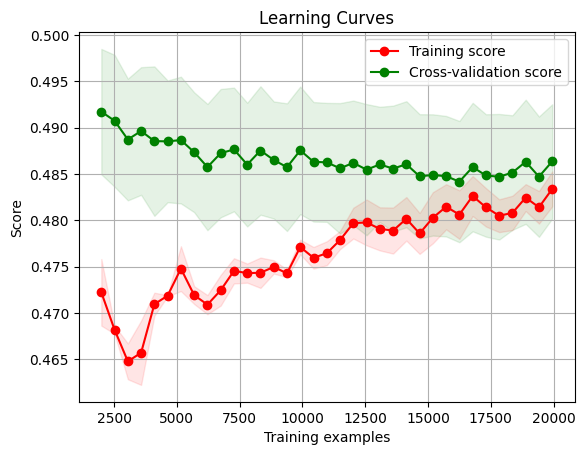

In [109]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 35))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    train_scores = np.sqrt(-train_mean)
    test_scores = np.sqrt(-test_mean)

    plt.figure()
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores - train_std, train_scores + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores - test_std, test_scores + test_std, alpha=0.1, color="g")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(model_gb_simplified, X_train, y_train)

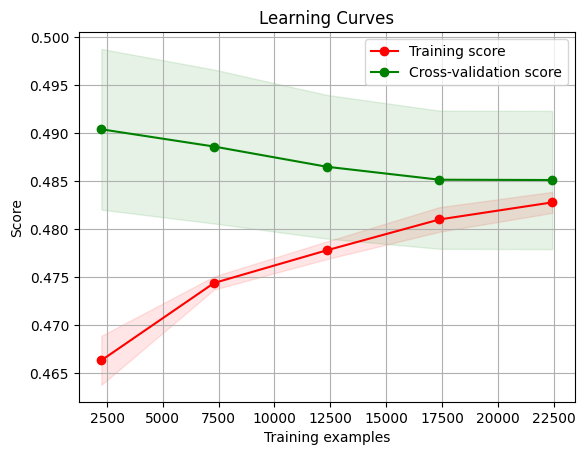

In [110]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=10, scoring='neg_mean_squared_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 5))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    train_scores = np.sqrt(-train_mean)
    test_scores = np.sqrt(-test_mean)

    plt.figure()
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores - train_std, train_scores + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores - test_std, test_scores + test_std, alpha=0.1, color="g")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(model_gb_simplified, X_train, y_train)
